# 1.Importing Libraries

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import warnings

warnings.filterwarnings('ignore')

In [38]:
tf.__version__

'2.16.1'

# 2.Importing Dataset

In [39]:
au2 = pd.read_csv('weatherAUS2.csv')
au2 = au2.drop(['Evaporation','Location','WindGustDir'], axis=1)

# Imputing Missing Values for categorical variables

In [40]:
s = (au2.dtypes == "object")
object_cols = list(s[s].index)
for i in object_cols:
    au2[i].fillna(au2[i].mode()[0], inplace=True)

# Imputing Missing Values for Numerical variables

In [41]:
t = (au2.dtypes == "float64")
num_cols = list(t[t].index)
for i in num_cols:
    au2[i].fillna(au2[i].median(), inplace=True)

# Feature Engineering to adjust to Sensor's attributes

In [42]:
avg_wind = (au2['WindSpeed3pm'] + au2['WindSpeed9am'])/2
avg_temp = (au2['MinTemp'] + au2["MaxTemp"])/2
avg_humidity = (au2['Humidity9am'] + au2['Humidity3pm'])/2
avg_pressure = (au2['Pressure3pm'] + au2['Pressure9am'])/2

In [43]:
df = au2[['Date','MinTemp','MaxTemp','Rainfall','Sunshine','RainToday','RainTomorrow']]
df['WindSpeed'] = avg_wind
df['Temperature'] = avg_temp
df['Humidity'] = avg_humidity
df['Pressure'] = avg_pressure
df['Wind Direction'] = au2['WindDir9am']

# Checking for Outliers with code and box plot

Using code, outliers are checked with quantile and is removed from dataset. Using boxplot, the outliers are visually visible

In [45]:
print(len(df))
t = (df.dtypes == "float64")
num_cols = list(t[t].index)

for i in num_cols:
    q1 = df[i].quantile(0.25)
    q3 = df[i].quantile(0.75)
    iqr = q3 - q1
    low = q1 - (1.5*iqr)
    up = q3 + (1.5*iqr)
    df = df[(df[i] > low) & (df[i] < up)]

145460


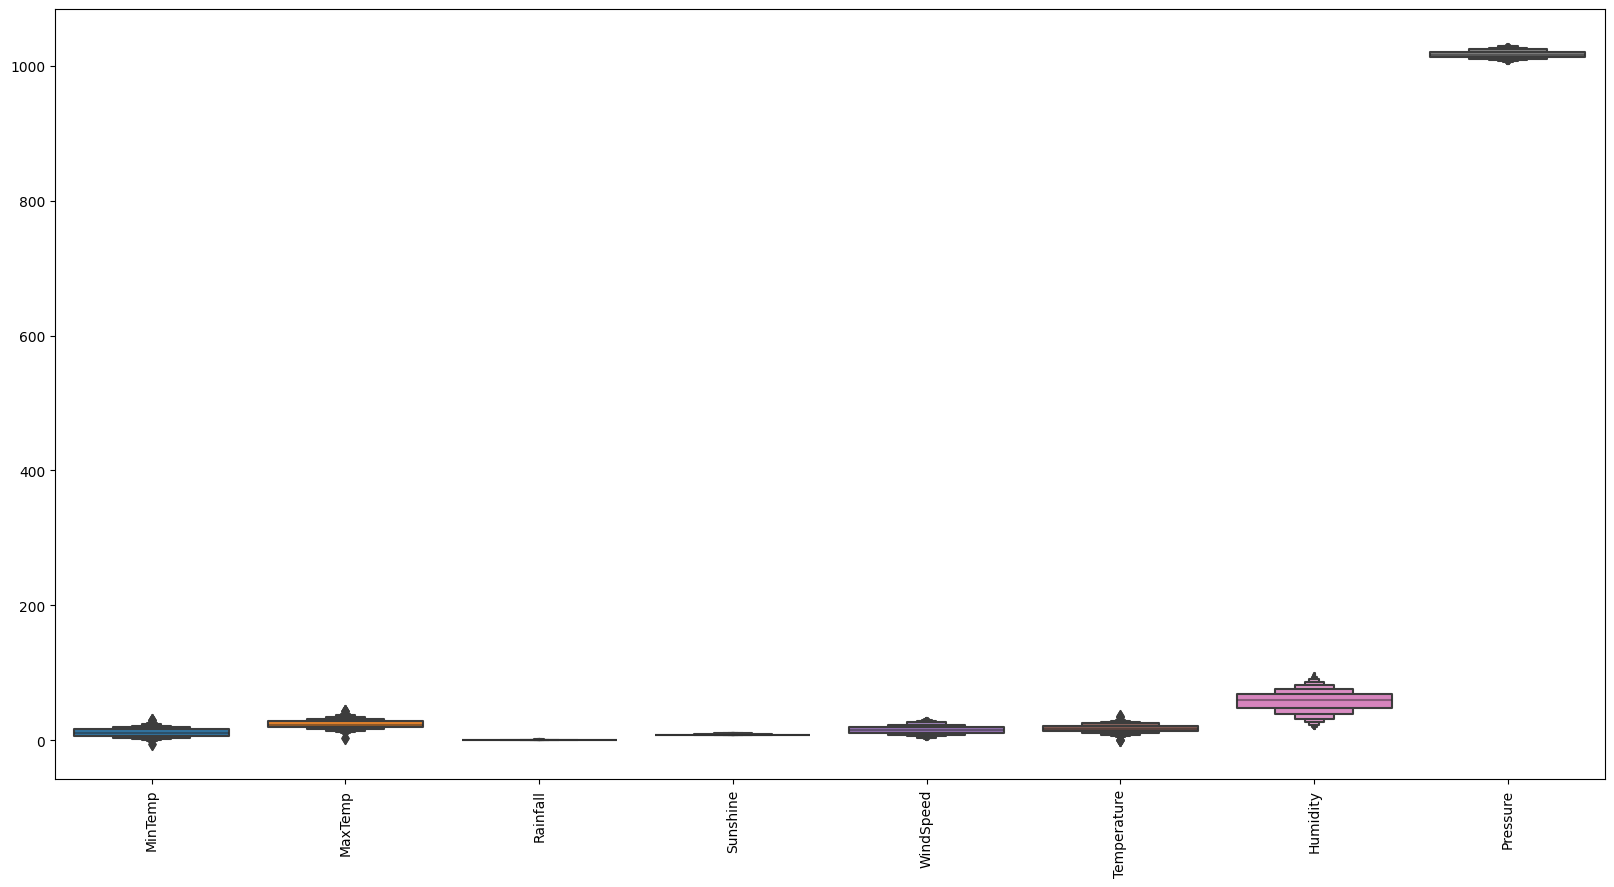

In [46]:
plt.figure(figsize=(20,10))
sns.boxenplot(data = df[num_cols])
plt.xticks(rotation=90)
plt.show()

In [47]:
df = df.drop('Date', axis=1)

# Encoding Categorical Variables with Label Encoder

In [49]:
from sklearn.preprocessing import LabelEncoder
s = (df.dtypes == "object")
object_cols = list(s[s].index)

le = LabelEncoder()
for i in object_cols:
    df[i] = le.fit_transform(df[i])

# Making new dataset


Using values from old dataset, a new dataset is constructed with the same attributes as sensor's attribute

In [79]:
min_temp = min(df['Temperature'])
#Max Temp: max temperature
max_temp = max(df['Temperature'])
#Rain Today: max of rain today
rain_today = max(df['RainToday'])
#Temperature: avg
temp = (df['Temperature'].sum()/len(df))
#Humidity: avg
hum = (df['Humidity'].sum()/len(df))
#Pressure : avg
press = (df['Pressure'].sum()/len(df))
#Sunshine: sum
suns = df['Sunshine'].sum()
#wind: avg
ws = df['WindSpeed'].sum()/len(df)
#rainfall: sum
rf = df['Rainfall'].sum()
#wind direction : mode
winddir =(df['Wind Direction'].mode()[0])
##v
val_list = [min_temp, max_temp, rf, suns, rain_today, ws,temp, hum, press, winddir]
columns = ['MinTemp', 'MaxTemp','Rainfall','Sunshine','RainToday','WindSpeed','Temperature','Humidity','Pressure','Wind Direction']
data = pd.DataFrame({
    'MinTemp': [min_temp],
    'MaxTemp': [max_temp],
    'Rainfall': [rf],
    'Sunshine': [suns],
    'RainToday': [rain_today],
    'WindSpeed': [ws],
    'Temperature': [temp],
    'Humidity': [hum],
    'Pressure': [press],
    'Wind Direction': [winddir]
})
data

,MinTemp,MaxTemp,Rainfall,Sunshine,RainToday,WindSpeed,Temperature,Humidity,Pressure,Wind Direction
0,-0.4,35.15,7277.2,645404.3,1,14.95312,17.433281,58.048262,1017.397424,3


# Splitting Dataset into training and testing

In [51]:
from sklearn.model_selection import train_test_split

features = df.drop('RainTomorrow', axis=1)
target = df['RainTomorrow']

x_train, x_test, y_train, y_test = train_test_split(features, target, train_size=0.8, random_state=42)

# Scaling dataset

In [52]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
nr = features.drop('RainToday', axis =1 )
sc_cols = nr.columns
x_train[sc_cols] = sc.fit_transform(x_train[sc_cols])
x_test[sc_cols] = sc.transform(x_test[sc_cols])

# Artificial Neural Network Model Building

This project uses artificial neural network with 4 relu (rectifier) layer and 1 drop-out layer to prevent overfitting. Output layer uses sigmoid function as the output is binary. Adam optimizer (Gradient Descent) is used with loss function of binary cross entropy and metrics accuracy.<br>
Batch size is set to 32 with 150 epochs/repetition, with 20% validation split.

In [53]:
nn = tf.keras.models.Sequential()
nn.add(tf.keras.layers.Dense(units=32, activation='relu'))
nn.add(tf.keras.layers.Dense(units=32, activation='relu'))
nn.add(tf.keras.layers.Dense(units=16, activation='relu'))
nn.add(tf.keras.layers.Dropout(0.25))
nn.add(tf.keras.layers.Dense(units=8, activation='relu'))
nn.add(tf.keras.layers.Dropout(0.5))

nn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
nn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
nn.fit(x_train, y_train, batch_size = 32, epochs = 150, validation_split=0.2)

Epoch 1/150


1499/1499 ━━━━━━━━━━━━━━━━━━━━ 2s 647us/step - accuracy: 0.8639 - loss: 0.4164 - val_accuracy: 0.8589 - val_loss: 0.3513
Epoch 2/150
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 1s 606us/step - accuracy: 0.8636 - loss: 0.3634 - val_accuracy: 0.8652 - val_loss: 0.3478
Epoch 3/150
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 1s 593us/step - accuracy: 0.8671 - loss: 0.3483 - val_accuracy: 0.8610 - val_loss: 0.3482
Epoch 4/150
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 1s 687us/step - accuracy: 0.8652 - loss: 0.3504 - val_accuracy: 0.8640 - val_loss: 0.3449
Epoch 5/150
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 1s 670us/step - accuracy: 0.8654 - loss: 0.3492 - val_accuracy: 0.8638 - val_loss: 0.3447
Epoch 6/150
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 1s 762us/step - accuracy: 0.8657 - loss: 0.3469 - val_accuracy: 0.8639 - val_loss: 0.3433
Epoch 7/150
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 1s 687us/step - accuracy: 0.8677 - loss: 0.3466 - val_accuracy: 0.8673 - val_loss: 0.3402
Epoch 8/150
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 1s 668us/step - accuracy: 0.8688 - los

In [54]:
y_pred = nn.predict(x_test)

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step


# Dumping Model for later-use

Using pickle, Scaler and Label encoders are dumped for later use as scaling and encoding are different each time called and consistent results are needed in terms of scaling and encoding.<br>

Using tensorflow, I saved artificial neural network model with the weights to save time from retraining every time.

In [58]:
from pickle import dump 
dump(sc, open("sc1.pkl","wb"))
dump(le, open("le1.pkl","wb"))

from tensorflow.keras.models import model_from_json
model_json = nn.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
nn.save_weights("model.weights.h5")
print("Saved model to disk")

Saved model to disk
